# Проект Маркетинг

## Описание

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

### Цель

Предсказать вероятность покупки в течение 90 дней

### Задачи

● Изучить данные  
● Разработать полезные признаки  
● Создать модель для классификации пользователей  
● Улучшить модель и максимизировать метрику roc_auc  
● Выполнить тестирование  

### Данные

apparel-purchases  
история покупок  
● client_id идентификатор пользователя  
● quantity количество товаров в заказе  
● price цена товара  
● category_ids вложенные категории, к которым отнсится товар  
● date дата покупки  
● message_id идентификатор сообщения из рассылки  

apparel-messages  
история рекламных рассылок  
● bulk_campaign_id идентификатор рекламной кампании  
● client_id идентификатор пользователя  
● message_id идентификатор сообщений  
● event тип действия  
● channel канал рассылки  
● date дата рассылки  
● created_at точное время создания сообщения  

apparel-target_binary  
совершит ли клиент покупку в течение следующих 90 дней  
● client_id идентификатор пользователя  
● target целевой признак  


## Подготовка к работе

### Импорты

In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from IPython.display import HTML, display
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import time
import re
import ast

### Константы

In [342]:
RANDOM_STATE = 20

### Функции

In [343]:
# форматирования текста
def format_display(text):
    return HTML(f"<span style='font-size: 1.5em; font-weight: bold; font-style: italic;'>{text}</span>")

# сделаем функцию оценки пропусков в датасетах
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    display(missing_data)

# функция для обработки пробелов
def process_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = ' '.join(s.split())
    return s

# замена пробелов на нижнее подчеркинвание в названии столбцов
def replace_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = '_'.join(s.split())
    return s

def drop_duplicated(data):
    # проверка дубликатов
    display(format_display("Проверим дубликаты и удалим, если есть"))
    num_duplicates = data.duplicated().sum()
    display(num_duplicates)
    
    if num_duplicates > 0:
        display("Удаляем")
        data = data.drop_duplicates(keep='first').reset_index(drop=True)  # обновляем DataFrame
    else:
        display("Дубликаты отсутствуют")
    return data

def normalize_columns(columns):
    new_cols = []
    for col in columns:
        # вставляем "_" перед заглавной буквой (латиница или кириллица), кроме первой
        col = re.sub(r'(?<!^)(?=[A-ZА-ЯЁ])', '_', col)
        # приводим к нижнему регистру
        col = col.lower()
        new_cols.append(col)
    return new_cols

def check_data(data):
    # приведем все к нижнему регистру
    data.columns = normalize_columns(data.columns)
    
    # удалим лишние пробелы в строках
    data = data.map(process_spaces)

    # и в названии столбцов
    data.columns = [replace_spaces(col) for col in data.columns]
    
    # общая информация 
    display(format_display("Общая информация базы данных"))
    display(data.info())
    
    # 5 строк
    display(format_display("5 случайных строк"))
    display(data.sample(5))
    
    # пропуски
    display(format_display("Число пропусков в базе данных"))
    display(missing_data(data))

    # проверка на наличие пропусков
    if data.isnull().sum().sum() > 0:
        display(format_display("Визуализация пропусков"))
        msno.bar(data)
        plt.show()
        
    # средние характеристики
    display(format_display("Характеристики базы данных"))
    display(data.describe().T)
    
    # data = drop_duplicated(data)
    
    return data  # возвращаем измененные данные

def parse_category_ids(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

def plot_combined(data, col=None, target=None, col_type=None, legend_loc='best'):
    """
    Строит графики для числовых столбцов в DataFrame, автоматически определяя их типы (дискретные или непрерывные).

    :param data: DataFrame, содержащий данные для визуализации.
    :param col: Список столбцов для построения графиков. Если None, будут использованы все числовые столбцы.
    :param target: Столбец, по которому будет производиться разделение (для hue в графиках).
    :param col_type: Словарь, определяющий типы столбцов ('col' для непрерывных и 'dis' для дискретных).
                     Если None, типы будут определены автоматически.
    :param legend_loc: Положение легенды для графиков (по умолчанию 'best').
    :return: None. Графики отображаются с помощью plt.show().
    """
    
    # Определяем числовые столбцы
    if col is None:
        numerical_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    else:
        numerical_columns = col

    # Если col_type не указан, определяем типы автоматически
    if col_type is None:
        col_type = {}
        for col in numerical_columns:
            unique_count = data[col].nunique()
            if unique_count > 20:
                col_type[col] = 'col'  # Непрерывные данные
            else:
                col_type[col] = 'dis'  # Дискретные данные

    total_plots = len(numerical_columns) * 2
    ncols = 2
    nrows = (total_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axs = axs.flatten()

    index = 0

    for col in numerical_columns:
        # Определяем тип графика
        plot_type = col_type.get(col)
        if plot_type is None:
            raise ValueError(f"Тип для столбца '{col}' не указан в col_type.")

        # Гистограмма или countplot
        if index < len(axs):
            if plot_type == 'col':
                if target is not None:
                    sns.histplot(data, x=col, hue=target, bins=20, kde=True, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.histplot(data[col].dropna(), bins=20, kde=True, ax=axs[index])
                axs[index].set_title(f'Гистограмма: {col}')
            elif plot_type == 'dis':
                if target is not None:
                    sns.countplot(data=data, x=col, hue=target, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.countplot(data=data, x=col, ax=axs[index])
                axs[index].set_title(f'Countplot: {col}')
                # поворот подписей X для дискретных
                axs[index].tick_params(axis='x', rotation=90)
            index += 1

        # Боксплот
        if index < len(axs):
            sns.boxplot(x=data[col], ax=axs[index])
            axs[index].set_title(f'Боксплот: {col}')
            # тоже поворачиваем, если дискретные значения
            if plot_type == 'dis':
                axs[index].tick_params(axis='x', rotation=90)
            index += 1

    # Отключаем оставшиеся оси
    for j in range(index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

## EDA

### Подключим и почитаем данные

In [344]:
app_msg = pd.read_csv("../data/apparel-messages.csv")
app_prch = pd.read_csv("../data/apparel-purchases.csv")
app_target = pd.read_csv("../data/apparel-target_binary.csv")
event_type = pd.read_csv("../data/full_campaign_daily_event.csv")
event_chanel = pd.read_csv("../data/full_campaign_daily_event_channel.csv")

### Первичная оценка и обработка данных

#### app_msg

In [345]:
app_msg = check_data(app_msg)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
3936487,9945,1515915625488636534,1515915625488636534-9945-63e34e7cbe982,send,email,2023-02-08,2023-02-08 07:40:19
9702778,14194,1515915625987282736,1515915625987282736-14194-65645af3be43b,send,mobile_push,2023-11-27,2023-11-27 10:03:54
2387318,7803,1515915625491258873,1515915625491258873-7803-636dfeb435a1c,click,email,2022-11-11,2022-11-11 09:31:47
8954434,14037,1515915625468092226,1515915625468092226-14037-6542400511580,open,mobile_push,2023-11-01,2023-11-01 14:39:40
10263517,14284,1515915625577709107,1515915625577709107-14284-6576ec21b7f49,open,mobile_push,2023-12-11,2023-12-11 11:08:23


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
bulk_campaign_id,12739798.0,1.160459e+04,3.259211e+03,5.480000e+02,8.746000e+03,1.351600e+04,1.415800e+04,1.465700e+04
client_id,12739798.0,1.515916e+18,1.329704e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18


In [346]:
# посмотрим дату начала и конца событий
first_date = app_msg['date'].min()
last_date = app_msg['date'].max()
display(first_date)
display(last_date)

'2022-05-19'

'2024-02-15'

In [347]:
# посмотрим уники среди событий и канал распространения
display(app_msg['event'].unique())
display(app_msg['channel'].unique())

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

array(['email', 'mobile_push'], dtype=object)

Что имеем:  
open — письмо открыто  
click — клик по ссылке в письме  
purchase — покупка после перехода из письма  
send — отправка письма  
unsubscribe — отписка от рассылки  
hbq_spam — сообщение отмечено как спам  
hard_bounce — письмо не доставлено из-за постоянной ошибки (адрес не существует)  
subscribe — подписка на рассылку  
soft_bounce — письмо не доставлено из-за временной ошибки (ящик переполнен, сервер недоступен)  
complain — жалоба пользователя (напр. “Это спам”)  
close — завершение сессии (иногда: закрытие письма или вкладки)  

In [348]:
# посмотри число дубликатов в базе
app_msg.duplicated().sum()

np.int64(48610)

Вот тут тонкий момент:  
1) Это косяк базы и надо просто удалить дубликаты и забыть про них;  
2) Сомнения имею я, что это косяк и скорее всего это спамер просто отправил несколько мессаг и тогда из этого можно сделать бинарную фичу, что-то типа "spam_factor"

In [349]:
# проверим сколько уникальных клиентов
display(app_msg['client_id'].nunique())

53329

Из 12.739.798 строк мы имеем 53.329 уникальных клиентов.  
Нужна будет пересборка данных с агрегацией

Выводы:  
Самая объемная база.  
Столбцы  date, created_at имеют неверный формат данных - необходимо будет преобразовать.


#### app_prch

In [350]:
app_prch = check_data(app_prch)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

,client_id,quantity,price,category_ids,date,message_id
6091,1515915625780988329,1,937.0,"['4', '28', '57', '431']",2022-06-01,1515915625780988329-4679-629722030001a
93332,1515915625501275723,1,66.0,"['5562', '5633', '5627', '573']",2023-03-22,1515915625501275723-11144-641ad1f329394
21459,1515915625559968668,1,2199.0,"['4', '31', '324', '1431']",2022-07-08,1515915625559968668-5286-62c52c04708db
113060,1515915625810816440,1,699.0,"['4', '28', '275', '421']",2023-04-28,1515915625810816440-12218-644b826d7755e
116196,1515915625576521259,1,979.0,"['4', '31', '326', '505']",2023-05-01,1515915625651274252-12218-644b8276f15ef


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
client_id,202208.0,1.515916e+18,1.459458e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
quantity,202208.0,1.006483e+00,1.843837e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+01
price,202208.0,1.193302e+03,1.342253e+03,1.000000e+00,3.520000e+02,9.870000e+02,1.699000e+03,8.549900e+04


In [351]:
# проверим сколько уникальных клиентов совершило покупки
display(app_prch['client_id'].nunique())

49849

In [352]:
display(app_prch['client_id'].nunique() / app_msg['client_id'].nunique())

0.934744698006713

Т.е. после всех событий произвели покупку 93.4% уникальных пользователей в текущей выборке, и почти 7% проигнорировало.  
В целом это очень хороший показатель.

In [353]:
# и еще посмотрим категории
app_prch[app_prch['category_ids'] == '[]']

,client_id,quantity,price,category_ids,date,message_id
22153,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
22154,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
49215,1515915625474537721,1,7.0,[],2022-11-12,1515915625474537721-7803-636dfed5eb8b6
53223,1515915625720375281,1,5.0,[],2022-11-13,1515915625720375281-7818-636f6ec29a382
59056,1515915625867975448,1,7.0,[],2022-11-16,1515915625766044118-7879-63748749d81b5
...,...,...,...,...,...,...
201990,1515915625641742458,1,7.0,[],2024-02-16,1515915625766077627-14668-65cf5246bd490
202068,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c
202069,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c
202144,1515915626007712189,1,12.0,[],2024-02-16,1515915626007712189-14648-65cdb6d1c0c2a


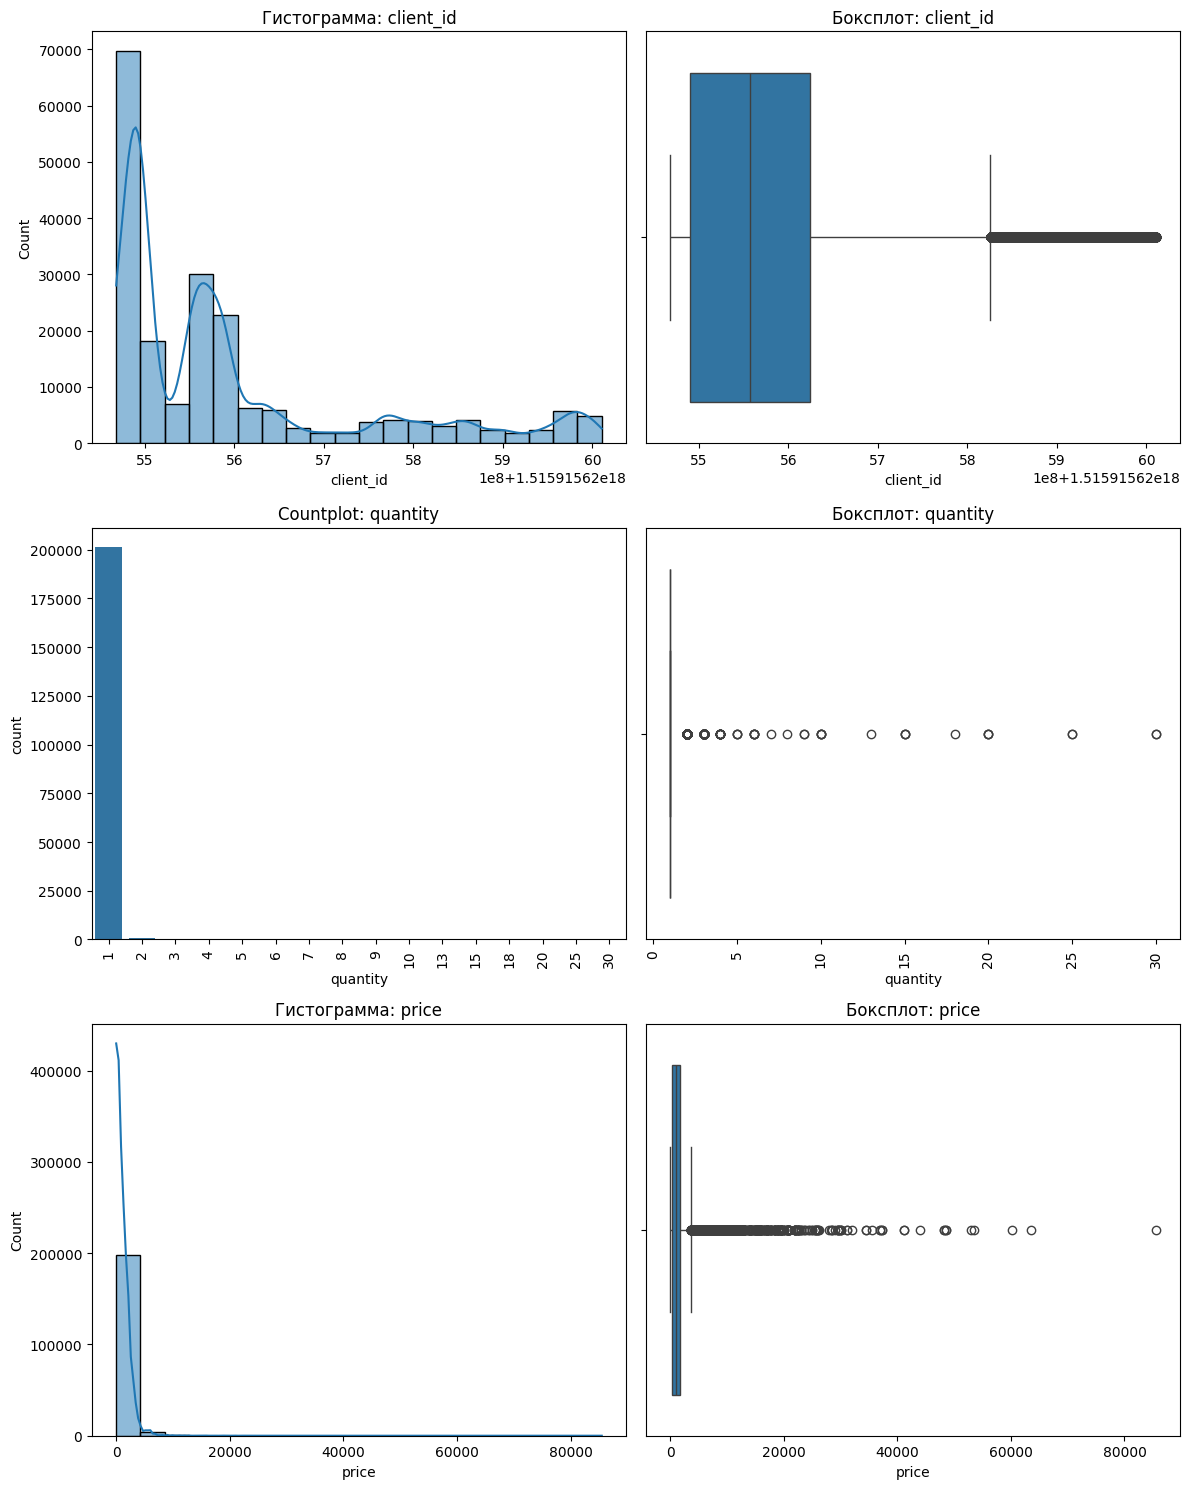

In [354]:
# тут еще заодно проведем более глубокий анализ данных
plot_combined(app_prch, col=None, target=None, col_type=None, legend_loc='best')

In [355]:
# здесь нам интересно глянуть цены, сколько нулей и где
app_prch[app_prch['price'] < 3]

,client_id,quantity,price,category_ids,date,message_id
20226,1515915625558928490,1,2.0,"['5562', '5597', '5691', '889']",2022-07-06,1515915625558928490-5286-62c52c06da8ee
21424,1515915625559762595,10,2.0,"['5562', '5597', '5691', '889']",2022-07-08,1515915625471544776-5335-62c7d2c4cc9fd
21425,1515915625559762595,10,2.0,"['5562', '5597', '5691', '889']",2022-07-08,1515915625471544776-5335-62c7d2c4cc9fd
22153,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
22154,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
...,...,...,...,...,...,...
199858,1515915625648416429,1,2.0,[],2024-02-09,1515915625648416429-14627-65c64f90a6f73
199859,1515915625648416429,1,2.0,[],2024-02-09,1515915625648416429-14627-65c64f90a6f73
201246,1515915625558967191,1,1.0,[],2024-02-14,1515915625980158750-14649-65cca1c3cc334
201247,1515915625558967191,1,1.0,[],2024-02-14,1515915625980158750-14649-65cca1c3cc334


Нулевых нет, уже хорошо.  
Ну, а цена в одну единицу в целом бывает.  
Также видим, что появились непонятные категории - пустые или None, что тоже не очень хорошо, но их обработает дальше.

Выводы:  
Столбец  date имеет неверный формат данных - необходимо будет преобразовать.  
Столбец category_ids - тут 2 варианта развития событий:  
- возьмем только глобальную категорию и конкретный товар, т.е. 1е и последнее значение;  
- можно будет преобразовывать в разряженную матрица, т.к. небольшой объем данных  
ну и потом с такой матрицей умеет работать xgboost который и будем использовать в предсказаниях;

#### app_target

In [356]:
app_target = check_data(app_target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

,client_id,target
35191,1515915625594341406,0
16131,1515915625491263785,0
34997,1515915625591285759,0
11619,1515915625489659005,0
22913,1515915625544014205,0


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
client_id,49849.0,1.515916e+18,1.487947e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
target,49849.0,1.927822e-02,1.375025e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


Выводы:  
Ну тут все понятно, обсуждать нечего

#### event_type

In [357]:
event_type = check_data(event_type)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

None

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
80856,2023-07-15,4956,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22959,2022-09-21,5403,0,0,0,84,0,0,0,0,...,83,0,0,0,0,3,0,0,0,0
116818,2024-03-18,14715,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9294,2022-07-14,2406,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
19544,2022-09-05,3749,0,0,0,10,0,0,0,0,...,10,0,0,0,0,0,0,0,0,0


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
bulk_campaign_id,131072.0,8416.743378,4877.369306,548.0,4116.0,7477.0,13732.0,15150.0
count_click,131072.0,90.982971,1275.503564,0.0,0.0,0.0,2.0,128453.0
count_complain,131072.0,0.932655,30.198326,0.0,0.0,0.0,0.0,5160.0
count_hard_bounce,131072.0,78.473434,1961.317826,0.0,0.0,0.0,0.0,287404.0
count_open,131072.0,3771.090691,65160.668444,0.0,1.0,6.0,30.0,5076151.0
count_purchase,131072.0,0.577927,9.107040,0.0,0.0,0.0,0.0,1077.0
count_send,131072.0,11634.142319,175709.508290,0.0,0.0,0.0,0.0,11543513.0
count_soft_bounce,131072.0,27.807312,736.944714,0.0,0.0,0.0,0.0,76284.0
count_subscribe,131072.0,0.140518,2.072777,0.0,0.0,0.0,0.0,189.0
count_unsubscribe,131072.0,6.362679,79.172069,0.0,0.0,0.0,1.0,9089.0


Вывод:  
Здесь просто агрегированная статистика по событиям, не вижу смысла, что-то делать с этой таблицей в принципе

#### event_chanel

In [358]:
event_chanel = check_data(event_chanel)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

None

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
112187,2024-02-27,14657,6,0,292,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3943,2022-06-14,4902,139,0,1991,0,0,0,224,3,...,19237,9676,3,19234,0,0,0,0,0,0
20812,2022-09-11,4617,2,0,29,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41458,2022-12-12,3169,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126902,2024-04-28,14719,0,0,78,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
bulk_campaign_id,131072.0,8416.743378,4877.369306,548.0,4116.0,7477.0,13732.0,15150.0
count_click_email,131072.0,41.582169,745.484035,0.0,0.0,0.0,1.0,59365.0
count_click_mobile_push,131072.0,49.400803,1036.952898,0.0,0.0,0.0,0.0,128453.0
count_open_email,131072.0,423.706032,9753.383722,0.0,1.0,5.0,23.0,2597015.0
count_open_mobile_push,131072.0,3347.384659,64448.590783,0.0,0.0,0.0,0.0,5076151.0
count_purchase_email,131072.0,0.357483,8.287483,0.0,0.0,0.0,0.0,1077.0
count_purchase_mobile_push,131072.0,0.220444,3.796500,0.0,0.0,0.0,0.0,431.0
count_soft_bounce_email,131072.0,24.474823,727.069387,0.0,0.0,0.0,0.0,76284.0
count_subscribe_email,131072.0,0.140518,2.072777,0.0,0.0,0.0,0.0,189.0
count_unsubscribe_email,131072.0,6.362679,79.172069,0.0,0.0,0.0,1.0,9089.0


Вывод:  
По сути своей, тоже самое, что и прошлая таблица - статистика по событиям.  
Возможно и есть смысл где-то использовать, но пока непонятно где и как

#### Выводы

Были подгружены и изучены предоставленные данные.  
Глобально, для реализации задачи нам понадобится только 3 таблицы - apparel-messages, apparel-purchases и apparel-target_binary, т.к. эти таблицы несут основную смысловую нагрузку.  
Две оставшиеся таблицы - статистика по ивентам и активности пользователей без привязки к этим самым пользователям и ничего нам не дадут.  



## Предобработка данных

### Обработка имеющихся данных

In [359]:
# преобразуем даты
app_msg["date"] = pd.to_datetime(app_msg["date"], errors="coerce")
app_msg["created_at"] = pd.to_datetime(app_msg["created_at"], errors="coerce")

app_prch["date"] = pd.to_datetime(app_prch["date"], errors="coerce")

### feature engineering

Для начала поработаем с каждой таблицей по отдельности и сделаем, что-то новое.  

app_msg
Что мы можем сделать:  
1) У нас есть дата реакции на ивент и дата создания ивента - скорость реакции на ивент, потом усредняем;  
2) Есть канал и действие - соберем суммарное число действий по каждому каналу;  
3) Сделать бинарную фичу "spam_factor", т.е. берем дубли, смотрим кого заспамили - тем 1, кого нет - 0.  

app_prch  
Что мы можем сделать:  
1) Время с момента последней покупки, сделаем в днях;  
2) Среднее число товаров в заказе;  
3) Средний чек заказа;  
4) Средняя цена итема;  
5) В какой категории больше всего покупок (предварительно разобьем category_ids на top и last id - глобальную категорию и конкретный товар);  
6) Любимый товар;  
7) Любимая категория;  
8) Средний интервал между покупками, в днях;  
9) Дней с последнего взаимодействия с рассылкой;  
10) Сделаем группировку по 30/60/90/180/360 дней, а там агрегируем по числу покупок, числу итемов, сумме затрат от последней имеющейся у нас отчетной даты;  

#### app_msg

In [360]:
app_msg.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [361]:
# У нас есть дата реакции на ивент и дата создания ивента - скорость реакции
app_msg["reaction_for_event"] = (
    (app_msg["date"].dt.normalize() - app_msg["created_at"].dt.normalize())
    .dt.days.astype("int16")
)

In [362]:
app_msg['reaction_for_event'].unique()

array([0], dtype=int16)

Неожиданно, все реагируют на ивенты в тот же день.  
В таком случае этот признак для нас бесполезен

In [363]:
# теперь агрегируем данные
app_msg_agg = (
    app_msg.groupby("client_id")
    .agg(
        bulk_campaigns=("bulk_campaign_id", "nunique"),             # сколько кампаний видел
        messages=("message_id", "nunique"),                         # сколько сообщений получил
        events=("event", "nunique"),                                # сколько уникальных событий
        channels=("channel", "nunique"),                            # через сколько каналов общались
        first_date=("date", "min"),                                 # первая дата активности
        last_date=("date", "max"),                                  # последняя дата активности
        pop_event=("event", lambda x: x.value_counts().idxmax())    # и самая популярная активность у юзера
    )
    .reset_index()
)

In [364]:
# считаем число действий по каналам и событиям
channel_event_counts = (
    pd.crosstab(
        index=app_msg["client_id"],
        columns=[app_msg["channel"], app_msg["event"]]
    )
)

# делаем имена колонок: actions_<channel>_<event>
channel_event_counts.columns = [
    f"actions_{ch}_{ev}" for ch, ev in channel_event_counts.columns
]

# собираем в кучу
channel_event_counts = channel_event_counts.reset_index()
app_msg_agg = app_msg_agg.merge(channel_event_counts, on="client_id", how="left")

In [365]:
# считаем количество дублей сообщений на юзера
dup_counts = (
    app_msg.groupby("client_id")
    .agg(dup_count=("message_id", lambda x: app_msg.loc[x.index].duplicated().sum()))
    .reset_index()
)

# spam_factor = 1 если дублей >= 2, иначе 0
dup_counts["spam_factor"] = (dup_counts["dup_count"] >= 2).astype(int)

# объединяем с агрегатами
app_msg_agg = app_msg_agg.merge(dup_counts, on="client_id", how="left")
app_msg_agg[["dup_count", "spam_factor"]] = app_msg_agg[["dup_count", "spam_factor"]].fillna(0).astype(int)

In [366]:
app_msg_agg[app_msg_agg["spam_factor"] == 1]

,client_id,bulk_campaigns,messages,events,channels,first_date,last_date,pop_event,actions_email_click,actions_email_complain,...,actions_email_unsubscribe,actions_mobile_push_click,actions_mobile_push_close,actions_mobile_push_hard_bounce,actions_mobile_push_open,actions_mobile_push_purchase,actions_mobile_push_send,actions_mobile_push_soft_bounce,dup_count,spam_factor
3,1515915625468061100,265,268,6,1,2022-05-19,2024-02-15,send,0,0,...,0,1,0,1,163,1,267,1,6,1
9,1515915625468061994,339,346,4,2,2022-05-25,2024-02-14,send,0,0,...,0,11,0,0,21,2,250,0,2,1
10,1515915625468062158,113,113,4,1,2022-05-20,2024-02-13,send,31,0,...,0,0,0,0,0,0,0,0,2,1
48,1515915625468064438,219,225,6,2,2022-05-19,2024-02-15,send,120,0,...,0,2,0,1,78,0,79,1,2,1
53,1515915625468064943,288,291,5,2,2022-05-19,2024-02-15,send,3,0,...,0,1,0,2,142,0,141,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53218,1515915626008498025,10,10,5,1,2024-01-22,2024-02-14,open,0,0,...,0,3,0,1,14,1,10,0,3,1
53219,1515915626008514147,4,4,4,1,2024-01-22,2024-02-02,click,0,0,...,0,7,0,0,4,2,4,0,2,1
53225,1515915626008582277,1,1,3,1,2024-01-22,2024-02-10,click,0,0,...,0,19,0,0,1,0,1,0,5,1
53248,1515915626009118362,4,4,5,1,2024-01-28,2024-02-14,click,0,0,...,0,7,0,1,3,2,4,0,2,1


In [367]:
display(app_msg_agg.head())
display(app_msg_agg.info())

,client_id,bulk_campaigns,messages,events,channels,first_date,last_date,pop_event,actions_email_click,actions_email_complain,...,actions_email_unsubscribe,actions_mobile_push_click,actions_mobile_push_close,actions_mobile_push_hard_bounce,actions_mobile_push_open,actions_mobile_push_purchase,actions_mobile_push_send,actions_mobile_push_soft_bounce,dup_count,spam_factor
0,1515915625468060902,127,127,5,1,2022-05-19,2024-01-19,send,10,0,...,1,0,0,0,0,0,0,0,0,0
1,1515915625468061003,154,154,4,1,2022-05-20,2024-02-13,send,6,0,...,0,0,0,0,0,0,0,0,1,0
2,1515915625468061099,215,215,4,2,2022-05-19,2024-02-13,send,8,0,...,0,0,0,2,34,0,58,0,0,0
3,1515915625468061100,265,268,6,1,2022-05-19,2024-02-15,send,0,0,...,0,1,0,1,163,1,267,1,6,1
4,1515915625468061170,240,243,4,2,2022-05-25,2024-02-15,send,16,0,...,0,0,0,0,12,0,79,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   client_id                        53329 non-null  int64         
 1   bulk_campaigns                   53329 non-null  int64         
 2   messages                         53329 non-null  int64         
 3   events                           53329 non-null  int64         
 4   channels                         53329 non-null  int64         
 5   first_date                       53329 non-null  datetime64[ns]
 6   last_date                        53329 non-null  datetime64[ns]
 7   pop_event                        53329 non-null  object        
 8   actions_email_click              53329 non-null  int64         
 9   actions_email_complain           53329 non-null  int64         
 10  actions_email_hard_bounce        53329 non-null  int64    

None

Выглядит жутко, но мы закрываем глаза и продолжаем делать :)

#### app_prch

In [368]:
# начнем с разбора category_ids
# превращаем в списки category_ids
app_prch["category_ids"] = app_prch["category_ids"].apply(parse_category_ids)

# берём первую категорию
app_prch["category_ids_top"] = app_prch["category_ids"].apply(
    lambda x: x[0] if len(x) > 0 else None
).astype("Int16")

# берём последнюю непустую категорию
app_prch["category_ids_last"] = app_prch["category_ids"].apply(
    lambda x: next((i for i in reversed(x) if i not in [None, "", "nan"]), None)
).astype("Int16")

In [370]:
# время с момента последней покупки (в днях)
last_date = pd.to_datetime(last_date)

last_purchase = (
    app_prch.groupby("client_id")["date"].max()
    .reset_index(name="last_purchase_date")
)

last_purchase["days_from_last_purchase"] = (
    (last_date - last_purchase["last_purchase_date"]).dt.days.astype("int16")
)
last_purchase.head()

,client_id,last_purchase_date,days_from_last_purchase
0,1515915625468060902,2022-05-27,629
1,1515915625468061003,2023-01-04,407
2,1515915625468061099,2022-05-17,639
3,1515915625468061100,2024-02-10,5
4,1515915625468061170,2023-06-17,243


In [371]:
# среднее число товаров в заказе
avg_items_per_order = (
    app_prch.groupby(["client_id", "message_id"])["quantity"].sum()
    .groupby("client_id").median()
    .reset_index(name="avg_items_per_order")
)
avg_items_per_order.head()

,client_id,avg_items_per_order
0,1515915625468060902,7.0
1,1515915625468061003,7.0
2,1515915625468061099,1.0
3,1515915625468061100,2.0
4,1515915625468061170,4.0


In [372]:
# средний чек заказа
avg_order_sum = (
    app_prch.groupby(["client_id", "message_id"])
    .apply(lambda df: (df["quantity"] * df["price"]).sum(), include_groups=False)
    .groupby("client_id").mean()
    .reset_index(name="avg_order_sum")
)
avg_order_sum.head()

,client_id,avg_order_sum
0,1515915625468060902,6993.000000
1,1515915625468061003,16235.000000
2,1515915625468061099,299.000000
3,1515915625468061100,2098.000000
4,1515915625468061170,11200.333333


In [373]:
# средняя цена итема
avg_item_price = (
    (app_prch["price"] * app_prch["quantity"])
    .groupby(app_prch["client_id"]).sum()
    / app_prch.groupby("client_id")["quantity"].sum()
)
avg_item_price = avg_item_price.reset_index(name="avg_item_price")
avg_item_price.head()

,client_id,avg_item_price
0,1515915625468060902,999.000000
1,1515915625468061003,2319.285714
2,1515915625468061099,299.000000
3,1515915625468061100,1049.000000
4,1515915625468061170,1768.473684


In [374]:
# любимая категория (top)
fav_category_top = (
    app_prch.groupby("client_id")["category_ids_top"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 0)
    .reset_index(name="fav_category_top")
)
fav_category_top.head()

,client_id,fav_category_top
0,1515915625468060902,4
1,1515915625468061003,4
2,1515915625468061099,4
3,1515915625468061100,4
4,1515915625468061170,4


In [375]:
# любимый товар (last)
fav_category_last = (
    app_prch.groupby("client_id")["category_ids_last"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 0)
    .reset_index(name="fav_category_last")
)
fav_category_last.head()

,client_id,fav_category_last
0,1515915625468060902,420
1,1515915625468061003,615
2,1515915625468061099,424
3,1515915625468061100,5717
4,1515915625468061170,420


In [385]:
# средний интервал между покупками (в днях)
avg_interval = (
    app_prch.groupby("client_id")["date"]
    .apply(
        lambda x: np.mean(np.diff(np.sort(x.unique())).astype("timedelta64[D]").astype(int))
        if x.nunique() > 1 else np.nan
    )
    .reset_index(name="avg_interval_days")
)
display(avg_interval.sample(5))
display(avg_interval.describe().T)

,client_id,avg_interval_days
1205,1515915625468157438,469.0
33617,1515915625587617474,4.0
34990,1515915625591285475,NaN
25508,1515915625557955325,NaN
6004,1515915625487279150,NaN


,count,mean,std,min,25%,50%,75%,max
client_id,49849.0,1.515916e+18,1.487947e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
avg_interval_days,7143.0,1.091847e+02,1.193527e+02,1.000000e+00,1.100000e+01,7.366667e+01,1.630000e+02,6.190000e+02


In [386]:
# сумма покупок
lifetime_value = (
    (app_prch["quantity"] * app_prch["price"])
    .groupby(app_prch["client_id"]).sum()
    .reset_index(name="lifetime_value")
)
display(lifetime_value.head())
display(lifetime_value.describe().T)

,client_id,lifetime_value
0,1515915625468060902,6993.0
1,1515915625468061003,16235.0
2,1515915625468061099,299.0
3,1515915625468061100,2098.0
4,1515915625468061170,33601.0


,count,mean,std,min,25%,50%,75%,max
client_id,49849.0,1.515916e+18,1.487947e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
lifetime_value,49849.0,4.865584e+03,7.351467e+03,1.000000e+00,1.499000e+03,2.969000e+03,5.698000e+03,5.404080e+05


In [378]:
# churn-флаг (>360 дней без покупок)
churn_flag = (
    app_prch.groupby("client_id")["date"].max()
    .reset_index(name="last_purchase_date")
)
churn_flag["churn_flag"] = (
    (last_date - churn_flag["last_purchase_date"]).dt.days > 360
).astype("int8")
churn_flag.head()

,client_id,last_purchase_date,churn_flag
0,1515915625468060902,2022-05-27,1
1,1515915625468061003,2023-01-04,1
2,1515915625468061099,2022-05-17,1
3,1515915625468061100,2024-02-10,0
4,1515915625468061170,2023-06-17,0


In [379]:
# агрегации по окнам 30/60/90/180/360 дней
def agg_period(df, cutoff_days):
    cutoff = last_date - pd.Timedelta(days=cutoff_days)
    dff = df[df["date"] >= cutoff]
    out = dff.groupby("client_id").agg(
        purchases=("message_id", "nunique"),
        items=("quantity", "sum"),
        cost=("price", lambda x: (dff.loc[x.index, "quantity"] * x).sum())
    )
    out = out.rename(columns={
        "purchases": f"purchases_{cutoff_days}d",
        "items": f"items_{cutoff_days}d",
        "cost": f"cost_{cutoff_days}d"
    })
    return out.reset_index()

agg_30 = agg_period(app_prch, 30)
agg_60 = agg_period(app_prch, 60)
agg_90 = agg_period(app_prch, 90)
agg_180 = agg_period(app_prch, 180)
agg_360 = agg_period(app_prch, 360)

agg_360.head()

,client_id,purchases_360d,items_360d,cost_360d
0,1515915625468061100,1,2,2098.0
1,1515915625468061170,3,19,33601.0
2,1515915625468062158,1,2,1398.0
3,1515915625468062184,1,4,3218.0
4,1515915625468062558,1,4,9096.0


In [380]:
# объединяем все в единый датафрейм client_features
app_prch_agg = last_purchase[["client_id", "days_from_last_purchase"]] \
    .merge(avg_items_per_order, on="client_id", how="left") \
    .merge(avg_order_sum, on="client_id", how="left") \
    .merge(avg_item_price, on="client_id", how="left") \
    .merge(fav_category_top, on="client_id", how="left") \
    .merge(fav_category_last, on="client_id", how="left") \
    .merge(avg_interval, on="client_id", how="left") \
    .merge(lifetime_value, on="client_id", how="left") \
    .merge(churn_flag[["client_id", "churn_flag"]], on="client_id", how="left") \
    .merge(agg_30, on="client_id", how="left") \
    .merge(agg_60, on="client_id", how="left") \
    .merge(agg_90, on="client_id", how="left") \
    .merge(agg_180, on="client_id", how="left") \
    .merge(agg_360, on="client_id", how="left")

app_prch_agg.head()

,client_id,days_from_last_purchase,avg_items_per_order,avg_order_sum,avg_item_price,fav_category_top,fav_category_last,avg_interval_days,lifetime_value,churn_flag,...,cost_60d,purchases_90d,items_90d,cost_90d,purchases_180d,items_180d,cost_180d,purchases_360d,items_360d,cost_360d
0,1515915625468060902,629,7.0,6993.000000,999.000000,4,420,NaN,6993.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1515915625468061003,407,7.0,16235.000000,2319.285714,4,615,NaN,16235.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1515915625468061099,639,1.0,299.000000,299.000000,4,424,NaN,299.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1515915625468061100,5,2.0,2098.000000,1049.000000,4,5717,NaN,2098.0,0,...,2098.0,1.0,2.0,2098.0,1.0,2.0,2098.0,1.0,2.0,2098.0
4,1515915625468061170,243,4.0,11200.333333,1768.473684,4,420,41.5,33601.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,19.0,33601.0
